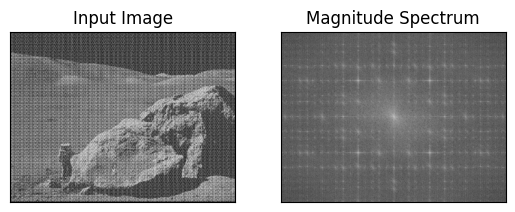

In [212]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('periodic_noise.JPG', cv.IMREAD_GRAYSCALE)

dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

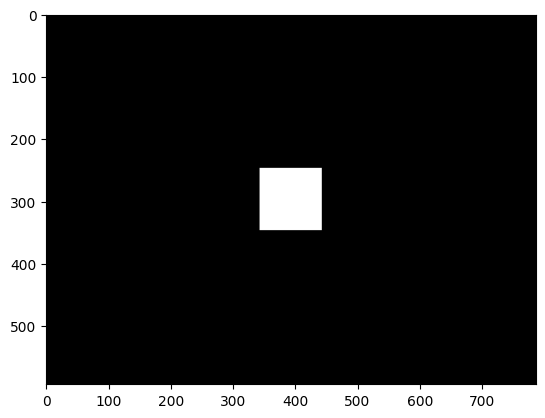

In [213]:
#Filter creating
# Low pass filter
mask_lpf = np.zeros((img.shape[0],img.shape[1],2),np.uint8)
centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))
mask_lpf[centerX-50:centerX+50, centerY - 50:centerY+50,:] = 1

plt.imshow(mask_lpf[:,:,0], cmap = 'gray')

## 1. Реализуйте высокочастотную фильтрацию на основе ядра Гаусса

In [214]:
#Filter creating
# High pass filter
blurred = cv.GaussianBlur(img, (9,9), 5)
img_hpf = cv.subtract(img, blurred)

## 2. Реализуйте удаление периодического шума

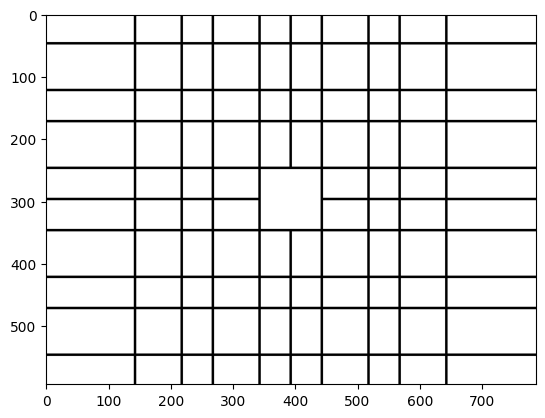

In [215]:
#Filter creating
# Periodic noise filter - manual lines
mask_pnf_l = np.ones((img.shape[0],img.shape[1],2),np.uint8)
centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))

line_width = 5
dist = [0, 50, 125, 175, 250]

for d in dist:
    # Vertical
    y_start = max(centerY + d - int(line_width/2), 0)
    y_end = min(centerY + d + int(line_width/2), img.shape[1])
    mask_pnf_l[:, y_start:y_end, :] = 0

    y_start = max(centerY - d - int(line_width/2), 0)
    y_end = min(centerY - d + int(line_width/2), img.shape[1])
    mask_pnf_l[:, y_start:y_end, :] = 0

    # Horizontal
    x_start = max(centerX + d - int(line_width/2), 0)
    x_end = min(centerX + d + int(line_width/2), img.shape[0])
    mask_pnf_l[x_start:x_end, :, :] = 0

    x_start = max(centerX - d - int(line_width/2), 0)
    x_end = min(centerX - d + int(line_width/2), img.shape[0])
    mask_pnf_l[x_start:x_end, :, :] = 0

mask_pnf_l[centerX-50+int(line_width/2):centerX+50-int(line_width/2), centerY - 50+int(line_width/2):centerY+50-int(line_width/2),:] = 1

plt.imshow(mask_pnf_l[:,:,0], cmap = 'gray')

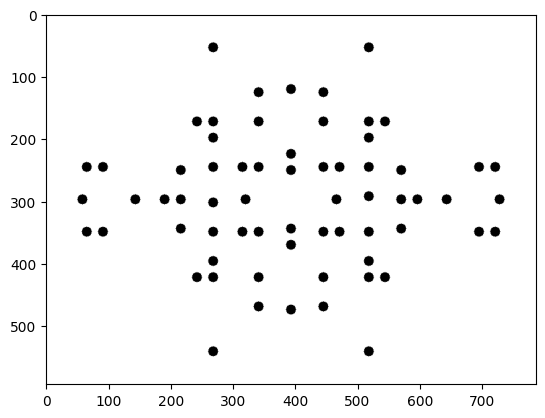

In [216]:
#Filter creating
# Periodic noise filter - peak_local_max
from skimage.feature import peak_local_max

mask_pnf_plm = np.ones((img.shape[0],img.shape[1],2),np.uint8)
centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))

min_distance = 15
threshold_abs =  260
noise_coords = peak_local_max(magnitude_spectrum, min_distance=min_distance, threshold_abs=threshold_abs)

for (y, x) in noise_coords:
    cv.circle(mask_pnf_plm, (x, y), 8, 0, -1)

mask_pnf_plm[centerX-10:centerX+10, centerY - 10:centerY+10,:] = 1
plt.imshow(mask_pnf_plm[:,:,0], cmap = 'gray')

In [217]:
# Filtering
dft_shift_lpf = dft_shift*mask_lpf
dft_shift_pnf_l = dft_shift*mask_pnf_l
dft_shift_pnf_plm = dft_shift*mask_pnf_plm

Text(0.5, 1.0, 'PNF - Peak Local Max')

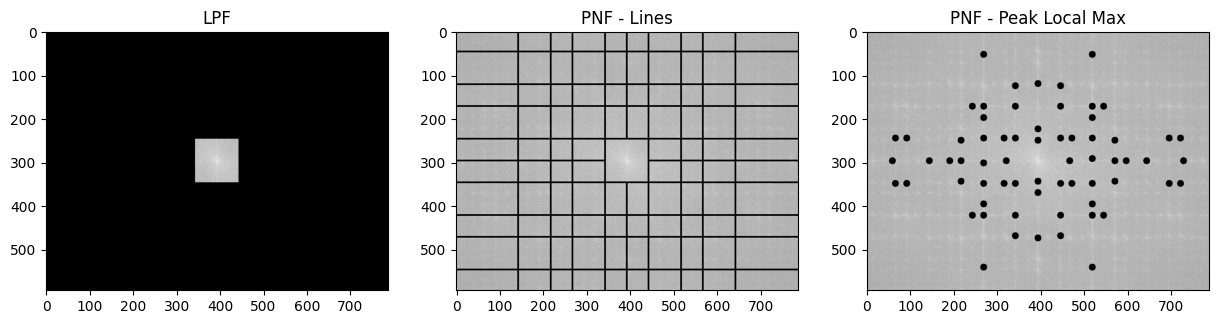

In [218]:
filtering_magn_res_lpf = 20*np.log(cv.magnitude(dft_shift_lpf[:,:,0], dft_shift_lpf[:,:,1])+1e-6)
filtering_magn_res_pnf_l = 20*np.log(cv.magnitude(dft_shift_pnf_l[:,:,0], dft_shift_pnf_l[:,:,1])+1e-6)
filtering_magn_res_pnf_plm = 20*np.log(cv.magnitude(dft_shift_pnf_plm[:,:,0], dft_shift_pnf_plm[:,:,1])+1e-6)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(filtering_magn_res_lpf, cmap='gray')
plt.title('LPF')

plt.subplot(1, 3, 2)
plt.imshow(filtering_magn_res_pnf_l, cmap='gray')
plt.title(f'PNF - Lines')

plt.subplot(1, 3, 3)
plt.imshow(filtering_magn_res_pnf_plm, cmap='gray')
plt.title(f'PNF - Peak Local Max')

In [219]:
#fshift = dft_shift*mask
f_ishift_lpf = np.fft.ifftshift(dft_shift_lpf)
img_back_lpf = cv.idft(f_ishift_lpf)
img_back_lpf = cv.magnitude(img_back_lpf[:,:,0],img_back_lpf[:,:,1])

f_ishift_pnf_l = np.fft.ifftshift(dft_shift_pnf_l)
img_back_pnf_l = cv.idft(f_ishift_pnf_l)
img_back_pnf_l = cv.magnitude(img_back_pnf_l[:,:,0],img_back_pnf_l[:,:,1])

f_ishift_pnf_plm = np.fft.ifftshift(dft_shift_pnf_plm)
img_back_pnf_plm = cv.idft(f_ishift_pnf_plm)
img_back_pnf_plm = cv.magnitude(img_back_pnf_plm[:,:,0],img_back_pnf_plm[:,:,1])

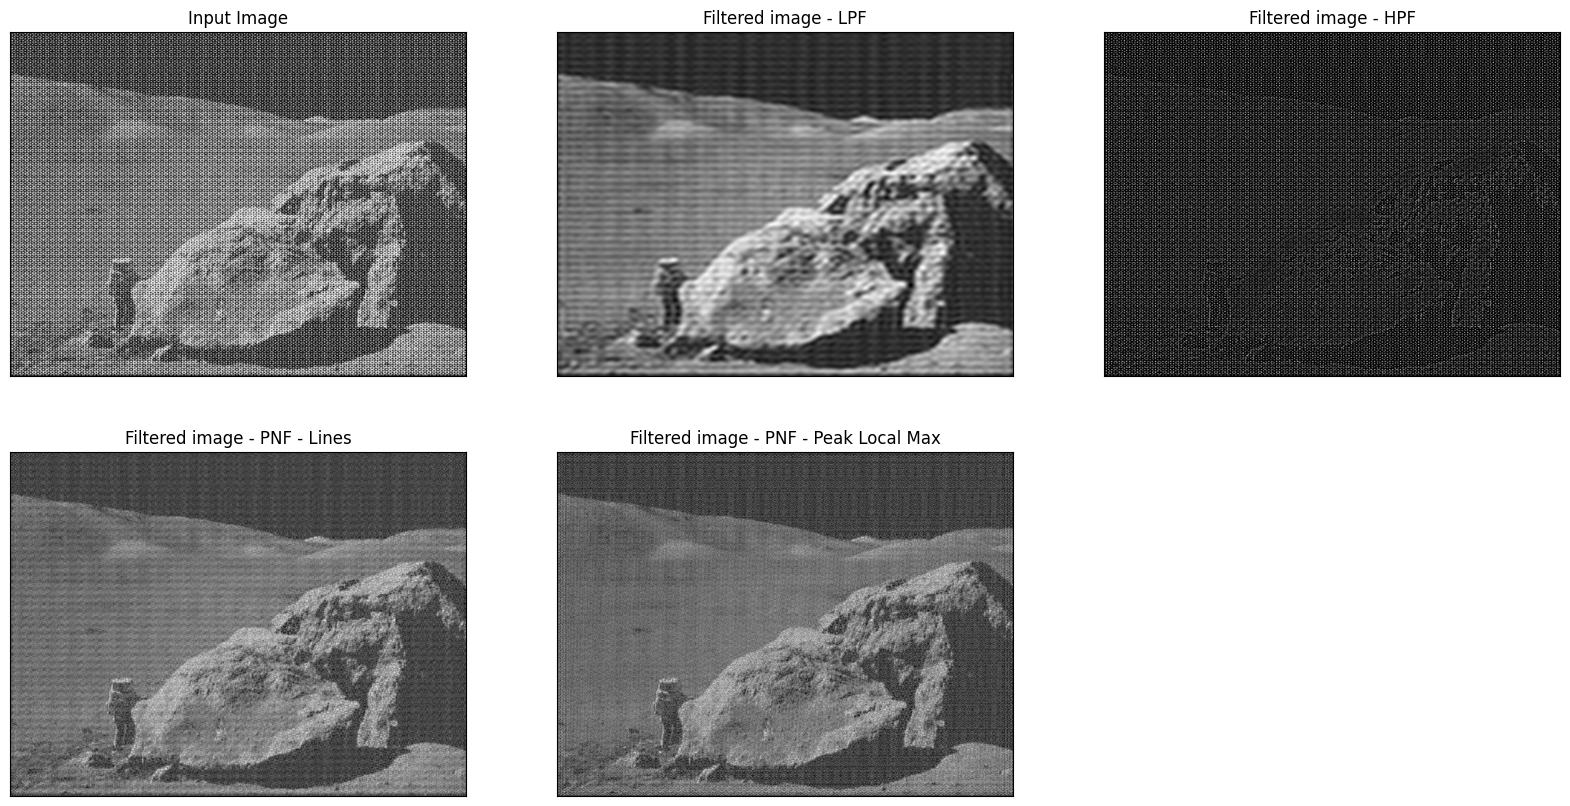

In [220]:
plt.figure(figsize=(20, 10))

plt.subplot(231),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(232),plt.imshow(img_back_lpf, cmap = 'gray')
plt.title('Filtered image - LPF'), plt.xticks([]), plt.yticks([])

plt.subplot(233),plt.imshow(img_hpf, cmap = 'gray')
plt.title('Filtered image - HPF'), plt.xticks([]), plt.yticks([])

plt.subplot(234),plt.imshow(img_back_pnf_l, cmap = 'gray')
plt.title('Filtered image - PNF - Lines'), plt.xticks([]), plt.yticks([])

plt.subplot(235),plt.imshow(img_back_pnf_plm, cmap = 'gray')
plt.title('Filtered image - PNF - Peak Local Max'), plt.xticks([]), plt.yticks([])

plt.show()

In [221]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума